# EDA and post-processing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
assert sys.version_info >= (3, 5)

from pathlib import Path
from pprint import pprint
import glob
import shutil
import json
import csv
import itertools
import pandas as pd
import numpy as np
from scipy import stats
from functools import partial, reduce
from time import time
from typing import List, Optional, Union

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score, f1_score, matthews_corrcoef,
                             roc_auc_score, recall_score, precision_score, precision_recall_curve)

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, auc, roc_curve

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

fdir = Path.cwd()
print(fdir)
sys.path.append(str(fdir/'..'))
import src
from src.config import cfg
from src.post_processing import scores_boxplot, scores_barplot

/vol/ml/apartin/projects/pdx-histo/nbs


# Tile counter per slide

In [2]:
tfr_dir = cfg.DATADIR/"PDX_FIXED_RSP_DRUG_PAIR"/"299px_302um"
tile_cnts = pd.read_csv(tfr_dir/"tile_counts_per_slide.csv")
print(tile_cnts.shape)

aa = tile_cnts.groupby("Response").agg({"max_tiles": "sum", "smp": "nunique", "Group": "nunique"}).reset_index().rename(
    columns={"max_tiles": "Tiles", "smp": "Samples", "Group": "Groups"})
display(aa)

print(aa.iloc[1,:]/aa.sum(axis=0))

(6962, 6)


,Response,Tiles,Samples,Groups
0,0,2517905,6631,917
1,1,141374,331,42


Response    1.000000
Tiles       0.053163
Samples     0.047544
Groups      0.043796
dtype: float64


# Calibration

In [3]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(name, fig_index, y_true, probs, verbose=True, figsize=(8, 8)):
    """ Plot calibration curve for est w/o and with calibration.
    https://towardsdatascience.com/classifier-calibration-7d0be1e05452
    """
    # fig = plt.figure(fig_index, figsize=figsize)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax1 = plt.subplot2grid(shape=(3, 1), loc=(0, 0), rowspan=2)
    ax2 = plt.subplot2grid(shape=(3, 1), loc=(2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    frac_of_pos, mean_pred_value = calibration_curve(y_true, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f"{name}")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="best")
    ax1.set_title(f"Calibration plot ({name})")

    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

    if verbose:
        print("Fraction of positives: {}".format(np.around(frac_of_pos, 3)))
        print("Mean prediction value: {}".format(np.around(mean_pred_value, 3)))
    return frac_of_pos, mean_pred_value

In [4]:
# split = 81
# split = 99
split = 76  # best scores
# split = 29
# split = 78

Fraction of positives: [0.002 0.087 0.254 0.413 0.48  0.494 0.454 0.58  0.71  0.994]
Mean prediction value: [0.016 0.144 0.244 0.345 0.447 0.548 0.65  0.753 0.846 0.971]


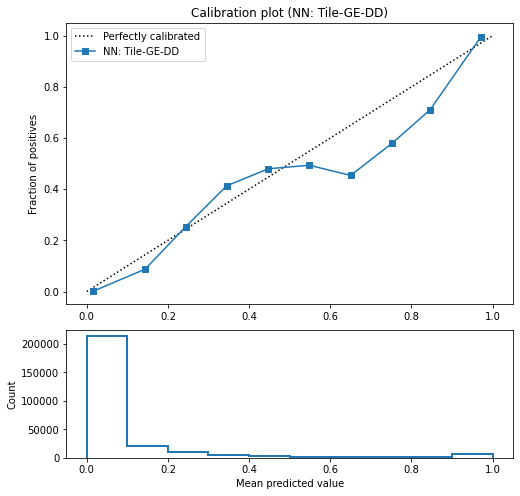

In [5]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"

preds = pd.read_csv(sorted(datadir.glob(f"split_{split}*"))[0]/"test_tile_preds.csv")
fop, mpv = plot_calibration_curve("NN: Tile-GE-DD", 1, y_true=preds["y_true"], probs=preds["prob"])

Fraction of positives: [0.    0.    0.05  0.154 0.222 0.364 1.    1.    1.    1.   ]
Mean prediction value: [0.021 0.14  0.25  0.356 0.448 0.551 0.638 0.795 0.853 0.986]


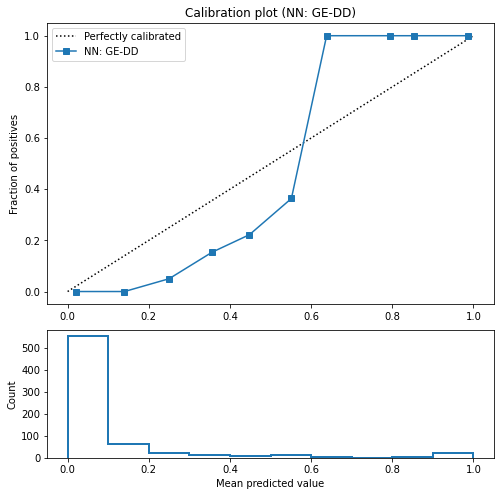

In [6]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd"

preds = pd.read_csv(sorted(datadir.glob(f"split_{split}*"))[0]/"test_keras_smp_preds.csv")
fop, mpv = plot_calibration_curve("NN: GE-DD", 1, y_true=preds["y_true"], probs=preds["prob"])

Fraction of positives: [0.013 0.3   0.308 0.    0.    0.    0.    0.25  1.    0.667]
Mean prediction value: [0.018 0.142 0.24  0.317 0.457 0.539 0.63  0.767 0.853 0.944]


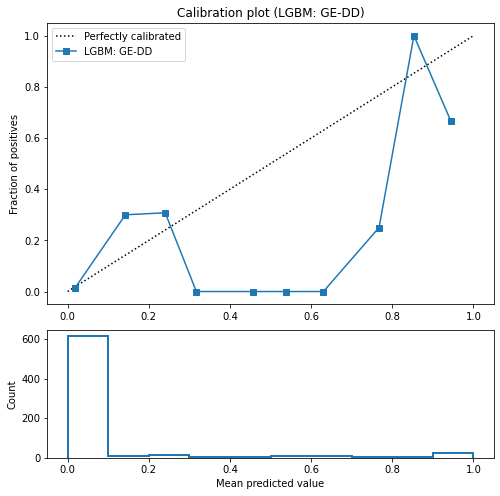

In [7]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../data/PDX_Transfer_Learning_Classification/Results_MultiModal_Learning/1.0_True_False_100_31"

preds = pd.read_csv(sorted(datadir.glob(f"cv_{split}*"))[0]/"test_preds.csv")
fop, mpv = plot_calibration_curve("LGBM: GE-DD", 1, y_true=preds["Response"], probs=preds["prediction"])

# Agg Scores

In [8]:
# dataname = "tidy_drug_pairs_all_samples"
# prjname = "bin_rsp_drug_pairs_all_samples"
# datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"
# preds = pd.read_csv(datadir/"split_99_tile_ge_dd1_dd2_2021-05-15_h04-m44/test_tile_preds.csv")
# print(preds.shape)
# display(preds[:2])

In [9]:
# ------------------------------------
# Multimodal
# ------------------------------------
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
fname = "test_scores.csv"

datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"
prfx = "split_"
splits_dir_list = sorted(datadir.glob(f"{prfx}*"))

all_te_scores = []
missing_scores = []
for split_dir in splits_dir_list:
    split_id = str(split_dir.name).split(prfx)[1].split("_")[0]
    fpath = split_dir/fname
    if (fpath).exists():
        te_scores = pd.read_csv(fpath)
        te_scores["split"] = int(split_id)
        all_te_scores.append(te_scores)
    else:
        missing_scores.append(split_id)

print(f"Test scores were found for these splits: {missing_scores}")
mm = pd.concat(all_te_scores, axis=0).sort_values("split").reset_index(drop=True)
mm = mm.rename(columns={"pred_for": "metric"})
del fpath, te_scores, all_te_scores

# ------------------------------------
# Single-modal
# ------------------------------------
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
fname = "test_keras_scores.csv"

datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd"
prfx = "split_"
splits_dir_list = sorted(datadir.glob(f"{prfx}*"))

all_te_scores = []
missing_scores = []
for split_dir in splits_dir_list:
    split_id = str(split_dir.name).split(prfx)[1].split("_")[0]
    fpath = split_dir/fname
    if fpath.exists():
        te_scores = pd.read_csv(fpath)
        te_scores["split"] = int(split_id)
        all_te_scores.append(te_scores)
    else:
        missing_scores.append(split_id)

print(f"Test scores were found for these splits: {missing_scores}")
sm = pd.concat(all_te_scores, axis=0).sort_values("split").reset_index(drop=True)
sm = sm.rename(columns={"pred_for": "metric"})
del fpath, te_scores, all_te_scores

# ------------------------------------
# LGBM
# ------------------------------------
lgb_datadir = fdir/"../data/PDX_Transfer_Learning_Classification/Results_MultiModal_Learning/1.0_True_False_100_31"
fname = "te_scores.csv"
prfx = "cv_"
splits_dir_list = sorted(lgb_datadir.glob(f"{prfx}*"))

all_te_scores = []
missing_scores = []
for split_dir in splits_dir_list:
    split_id = str(split_dir.name).split(prfx)[1].split("_")[0]
    fpath = split_dir/fname
    if (fpath).exists():
        te_scores = pd.read_csv(fpath)
        te_scores["split"] = int(split_id)
        all_te_scores.append(te_scores)
    else:
        missing_scores.append(split_id)

print(f"Test scores were found for these splits: {missing_scores}")
lgb = pd.concat(all_te_scores, axis=0).sort_values("split").reset_index(drop=True)
del fpath, te_scores, all_te_scores

s1 = set(mm["metric"].values)
s2 = set(sm["metric"].values)
s3 = set(lgb["metric"].values)
common_metrics = list(reduce(set.intersection, [s1, s2, s3]))

mm = mm[mm["metric"].isin(common_metrics)].sort_values(["split", "metric"])
sm = sm[sm["metric"].isin(common_metrics)].sort_values(["split", "metric"])
lgb = lgb[lgb["metric"].isin(common_metrics)].sort_values(["split", "metric"])

mm["model"] = "NN: Tile-GE-DD"
sm["model"] = "NN: GE-DD"
lgb["model"] = "LGBM: GE-DD"

# Rename items
def rename_items_of_single_col(x, mapper_dict):
    """ mapper_dict where keys and values are the old and new values, respectively. """
    for k, v in mapper_dict.items():
        if k == x:
            return mapper_dict[k]
    return x

mapper = {"brier": "Brier", "mcc": "MCC", "pr_auc": "PRC-AUC", "roc_auc": "ROC-AUC"}
mm["metric"] = mm["metric"].map(lambda x: rename_items_of_single_col(x, mapper))
sm["metric"] = sm["metric"].map(lambda x: rename_items_of_single_col(x, mapper))
lgb["metric"] = lgb["metric"].map(lambda x: rename_items_of_single_col(x, mapper))

print(mm.shape)
print(sm.shape)
print(lgb.shape)

cols = ["metric", "smp", "Group", "split", "model"]
all_scores = pd.concat([mm[cols], sm[cols], lgb[cols]], axis=0).reset_index(drop=True)
print(all_scores.shape)
# all_scores[:8]

Test scores were found for these splits: []
Test scores were found for these splits: []
Test scores were found for these splits: []


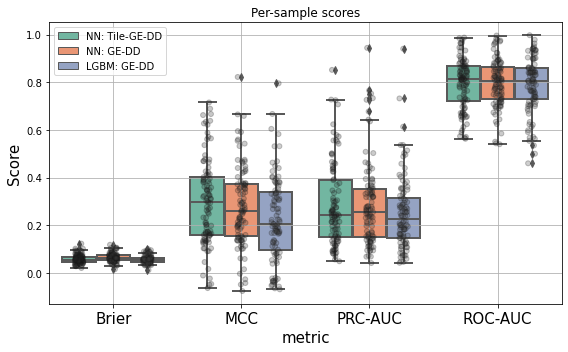

In [12]:
ax = scores_boxplot(df=all_scores, x_name="metric", y_name="smp", hue_name="model", title="Per-sample scores")

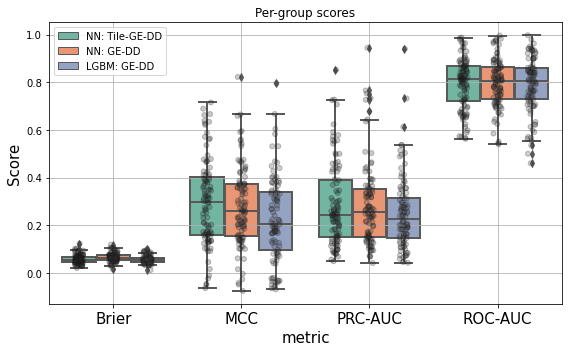

In [13]:
ax = scores_boxplot(df=all_scores, x_name="metric", y_name="smp", hue_name="model", title="Per-group scores")

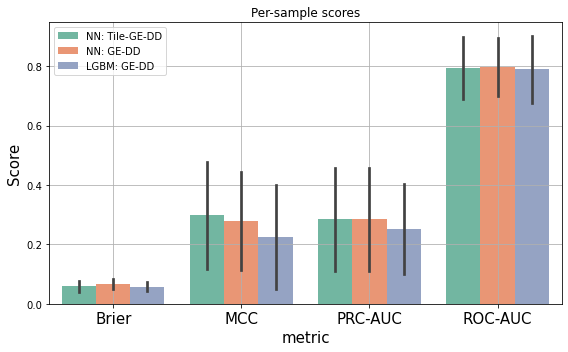

In [15]:
ax = scores_barplot(df=all_scores, x_name="metric", y_name="smp", hue_name="model", title=f"Per-sample scores")

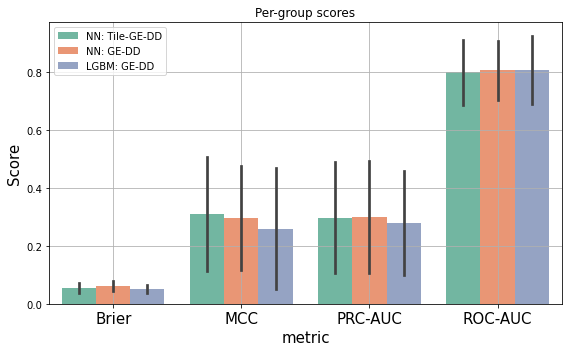

In [16]:
ax = scores_barplot(df=all_scores, x_name="metric", y_name="Group", hue_name="model", title=f"Per-group scores")

In [15]:
def t_test(scores, splits=None, met="PRC-AUC", agg_by="smp"):
    if splits is not None:
        scores = scores[scores["split"].isin(splits)]

    a = scores[(scores["metric"] == met) & (scores["model"] == "NN: Tile-GE-DD")][agg_by]
    b = scores[(scores["metric"] == met) & (scores["model"] == "NN: GE-DD")][agg_by]
    c = scores[(scores["metric"] == met) & (scores["model"] == "LGBM: GE-DD")][agg_by]

    print(stats.shapiro(a))
    print(stats.shapiro(b))
    print(stats.shapiro(c))

    print(stats.ttest_rel(a, b, axis=0, alternative="two-sided"))
    print(stats.ttest_rel(a, c, axis=0, alternative="two-sided"))
    print(stats.ttest_rel(b, c, axis=0, alternative="two-sided"))

In [16]:
t_test(all_scores, met="PRC-AUC", agg_by="smp")

ShapiroResult(statistic=0.9137418270111084, pvalue=6.652476258750539e-06)
ShapiroResult(statistic=0.8814291954040527, pvalue=2.0870916728199518e-07)
ShapiroResult(statistic=0.8981651067733765, pvalue=1.1602598988247337e-06)
Ttest_relResult(statistic=0.09101840336180504, pvalue=0.9276618755222322)
Ttest_relResult(statistic=2.472384453791115, pvalue=0.015126559007368628)
Ttest_relResult(statistic=2.5045100587026194, pvalue=0.013895351327625427)


In [17]:
# split = 76
# agg_by = "smp"
# ax = scores_barplot(df=all_scores[all_scores["split"].isin([split])], x_name="metric", y_name=agg_by, hue_name="model", title=f"Per-sample scores (split {split})")

# split = 99
# agg_by = "smp"
# ax = scores_barplot(df=all_scores[all_scores["split"].isin([split])], x_name="metric", y_name=agg_by, hue_name="model", title=f"Per-sample scores (split {split})")

In [19]:
# split = 99
# print(f"Split {split}")
# display(pd.pivot(all_scores[all_scores["split"]==split], index="metric", columns="model", values=["smp", "Group"]))

# split = 81
# print(f"Split {split}")
# display(pd.pivot(all_scores[all_scores["split"]==split], index="metric", columns="model", values=["smp", "Group"]))

In [20]:
# df = all_scores
# split = 99
# met = "PRC-AUC"
# df[(df["split"]==split) & (df["metric"]==met)]

In [21]:
# split = 81
# met = "PRC-AUC"
# df[(df["split"]==split) & (df["metric"]==met)]

In [36]:
# met = "PRC-AUC"
# j = all_scores
# n = 30
# j1 = j[(j["metric"] == met) & (j["model"] == "NN: Tile-GE-DD")].sort_values("smp", ascending=False)
# j2 = j[(j["metric"] == met) & (j["model"] == "NN: GE-DD")].sort_values("smp", ascending=False)
# j3 = j[(j["metric"] == met) & (j["model"] == "LGBM: GE-DD")].sort_values("smp", ascending=False)

# s1 = j1[:n]["split"].values
# s2 = j2[:n]["split"].values
# s3 = j3[:n]["split"].values

# from functools import reduce
# splits = list(reduce(set.union, [set(item) for item in [s1, s2, s3]]))

In [37]:
# t_test(all_scores, splits=splits, met="PRC-AUC", agg_by="smp")

ShapiroResult(statistic=0.9670884013175964, pvalue=0.8354851603507996)
ShapiroResult(statistic=0.9560458660125732, pvalue=0.6578039526939392)
ShapiroResult(statistic=0.9194589257240295, pvalue=0.21598698198795319)
Ttest_relResult(statistic=-0.28268346831637503, pvalue=0.7818703327837523)
Ttest_relResult(statistic=1.3227656094060627, pvalue=0.20871098247445713)
Ttest_relResult(statistic=1.3556782413044424, pvalue=0.19828588260417357)


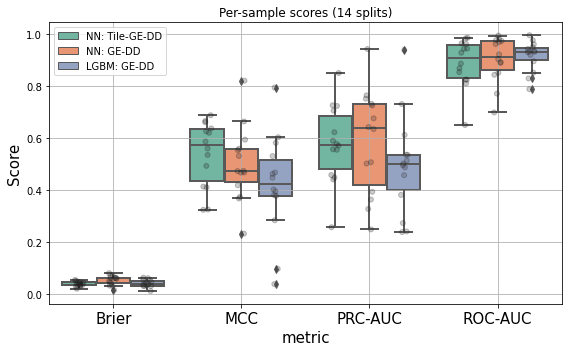

In [38]:
# xx = all_scores[all_scores["split"].isin(splits)]
# ax = scores_boxplot(df=xx, x_name="metric", y_name="smp", hue_name="model", title=f"Per-sample scores ({len(splits)} splits)")

# Error analysis

### Tile-GE-DD

In [18]:
from src.models import calc_tf_preds, agg_tile_preds

def add_conf_data(data, label_col_name, prob_col_name, p=0.5):
    """ Add columns are used to calc confusion matrix TP, TN, FN, FP. """
    if "TP" not in data.columns:
        data["TP"] = data.apply(lambda row: row[prob_col_name]>=p if row[label_col_name]==1 else False, axis=1)  # tp
    if "TN" not in data.columns:
        data["TN"] = data.apply(lambda row: row[prob_col_name] <p if row[label_col_name]==0 else False, axis=1)  # tn
    if "FN" not in data.columns:
        data["FN"] = data.apply(lambda row: row[prob_col_name] <p if row[label_col_name]==1 else False, axis=1)  # fn
    if "FP" not in data.columns:
        data["FP"] = data.apply(lambda row: row[prob_col_name]>=p if row[label_col_name]==0 else False, axis=1)  # fp

#     data['TPR'] = data.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.TP / (row.TP + row.FN), axis=1)  # sensitivity, recall: TP/P = TP/(TP+FN)
#     data['TNR'] = data.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.TN / (row.TN + row.FP), axis=1)  # specificity: TN/N = TN/(TN+FP)
    
#     data['FPR'] = data.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.FP / (row.TN + row.FP), axis=1)  # fall-out: FP/N = FP/(FP+TN)
#     data['FNR'] = data.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.FN / (row.TP + row.FN), axis=1)  # miss-rate: FN/NP = FN/(FN+TP)
    return data

In [19]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"

rundir = sorted(datadir.glob("split_99*"))[0]
mm_tile_preds = pd.read_csv(rundir/"test_tile_preds.csv").sort_values("smp")
meta = pd.read_csv(rundir/"te_meta.csv")

cols = ["smp", "Sample", "trt", "Group", "ctype", "image_id"]

# print(f"Unique Samples:    {df['Sample'].nunique()}")
# print(f"Unique treatments: {df['trt'].nunique()}")
# print(f"Unique groups:     {df['Group'].nunique()}")
# print(f"Unique ctypes:     {df['ctype'].nunique()}")

In [20]:
# mm_tile_preds = mm_tile_preds.sort_values("smp")
mm_tile_preds

,smp,tile_id,prob,y_true,y_pred_label
199918,114551~080-T~M667M226C29_NSC.125973_NSC.747599,212,0.1644,0,0
203256,114551~080-T~M667M226C29_NSC.125973_NSC.747599,336,0.2830,0,0
195395,114551~080-T~M667M226C29_NSC.125973_NSC.747599,44,0.2368,0,0
199837,114551~080-T~M667M226C29_NSC.125973_NSC.747599,209,0.2078,0,0
207540,114551~080-T~M667M226C29_NSC.125973_NSC.747599,495,0.2678,0,0
...,...,...,...,...,...
129084,SA0426~F1136~M622_NSC.754352_NSC.754352,166,0.9990,0,1
143925,SA0426~F1136~M622_NSC.754352_NSC.754352,717,0.9990,0,1
129057,SA0426~F1136~M622_NSC.754352_NSC.754352,165,0.9990,0,1
129138,SA0426~F1136~M622_NSC.754352_NSC.754352,168,0.9990,0,1


In [21]:
# # ---------------
# # Check passage
# # ---------------
# vv = meta["sample_id"].values

# out = []
# cnt = []
# p_id_problem = []
# for i, value in enumerate(vv):
#     if value.upper() == "ORIGINATOR":
#         out.append("ORIGINATOR")
#     elif "AL" in value.upper():
#         # print("Alternative site.")
#         cnt.append(value.upper())
#     elif "RG" in value.upper():
#         # print("Regrowth from a viably cryo-preserved fragment.")
#         out.append("RG")
#         cnt.append(value.upper())
#     elif "POOL" in value.upper():
#         # print("Pooled.")
#         cnt.append(value.upper())
#     elif ("PDC" or "CAF") in value.upper():
#         # print("PDC or CAF.")
#         cnt.append(value.upper())
#     else:
#         if len(value) % 3 != 0:
#             # print("Problem with passage ID")
#             p_id_problem.append(value)
#         else:
#             out.append("P" + str(int(len(value)/3)))
            
# print(cnt)
# print(p_id_problem)

In [22]:
mm_smp_preds = agg_tile_preds(mm_tile_preds, agg_by="smp", meta=meta, agg_method="mean")
mm_smp_preds = mm_smp_preds[cols + ["prob", "Response"]]
mm_smp_preds = add_conf_data(mm_smp_preds, label_col_name="Response", prob_col_name="prob", p=0.5)
mm_smp_preds.sort_values("smp")#[:4]

,smp,Sample,trt,Group,ctype,image_id,prob,Response,TP,TN,FN,FP
1,114551~080-T~M667M226C29_NSC.125973_NSC.747599,114551~080-T~M667M226C29,NSC.125973_NSC.747599,334,head & neck,16142,0.203689,0,False,True,False,False
0,114551~080-T~M667M226C29_NSC.747599_NSC.125973,114551~080-T~M667M226C29,NSC.747599_NSC.125973,334,head & neck,16142,0.303500,0,False,True,False,False
3,114551~080-T~M667M227C30_NSC.125973_NSC.747599,114551~080-T~M667M227C30,NSC.125973_NSC.747599,334,head & neck,16131,0.237451,0,False,True,False,False
2,114551~080-T~M667M227C30_NSC.747599_NSC.125973,114551~080-T~M667M227C30,NSC.747599_NSC.125973,334,head & neck,16131,0.312368,0,False,True,False,False
5,114551~080-T~M667M228C43_NSC.125973_NSC.747599,114551~080-T~M667M228C43,NSC.125973_NSC.747599,334,head & neck,16149,0.340601,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
691,SA0426~F1136~M621M949M475_NSC.754352_NSC.754352,SA0426~F1136~M621M949M475,NSC.754352_NSC.754352,954,sarcoma/mesothelioma,43821,0.998939,0,False,False,False,True
692,SA0426~F1136~M621M949M483_NSC.754352_NSC.754352,SA0426~F1136~M621M949M483,NSC.754352_NSC.754352,954,sarcoma/mesothelioma,17614,0.998946,0,False,False,False,True
689,SA0426~F1136~M621_NSC.754352_NSC.754352,SA0426~F1136~M621,NSC.754352_NSC.754352,954,sarcoma/mesothelioma,17103,0.999023,0,False,False,False,True
694,SA0426~F1136~M622M285_NSC.754352_NSC.754352,SA0426~F1136~M622M285,NSC.754352_NSC.754352,954,sarcoma/mesothelioma,17652,0.998978,0,False,False,False,True


In [23]:
# fop, mpv = plot_calibration_curve("NN: Tile-GE-DD", 1, y_true=mm_smp_preds["Response"], probs=mm_smp_preds["prob"])

In [24]:
# False positives
aa = mm_smp_preds[mm_smp_preds["FP"]].sort_values(["ctype", "prob"])
print(aa.shape)
# aa

(21, 12)


In [25]:
# split_on = "Group"
# meta.groupby(["ctype", "Response"]).agg({split_on: "nunique", "smp": "nunique"}).reset_index().rename(
#     columns={split_on: f"{split_on}_unq", "smp": "smp_unq"})

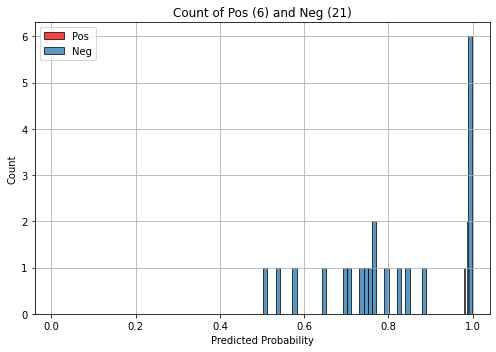

In [26]:
figsize=(7, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

df = mm_smp_preds
# pos_df = df[df["Response"]==1]
# neg_df = df[df["Response"]==0]
pos_df = df[(df["Response"]==1) & (df["prob"]>=0.5)]
neg_df = df[(df["Response"]==0) & (df["prob"]>=0.5)]

ax = sns.histplot(pos_df["prob"], bins=50, kde=False, ax=ax, color='r', label="Pos");
ax = sns.histplot(neg_df["prob"], bins=50, kde=False, ax=ax, label="Neg");
ax.set_title('Count of Pos ({}) and Neg ({})'.format( pos_df.shape[0], neg_df.shape[0] ))
ax.set_ylabel('Count');
ax.set_xlabel('Predicted Probability');
ax.set_xlim(left=-0.04, right=1.04)
ax.grid(True)
ax.legend();

plt.tight_layout()
# plt.savefig(out_postproc_fpath/'FNs_FPs_hist_all.png', dpi=150)

### GE-DD

In [27]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd"

rundir = sorted(datadir.glob("split_99*"))[0]
sm_smp_preds = pd.read_csv(rundir/"test_keras_smp_preds.csv")
meta = pd.read_csv(rundir/"te_meta.csv")

In [28]:
sm_smp_preds = sm_smp_preds[cols + ["prob", "Response"]]
sm_smp_preds = add_conf_data(data=sm_smp_preds, label_col_name="Response", prob_col_name="prob", p=0.5)
sm_smp_preds[:4]

,smp,Sample,trt,Group,ctype,image_id,prob,Response,TP,TN,FN,FP
0,114551~080-T~M667M226C29_NSC.747599_NSC.125973,114551~080-T~M667M226C29,NSC.747599_NSC.125973,334,head & neck,16142,0.3267,0,False,True,False,False
1,114551~080-T~M667M226C29_NSC.125973_NSC.747599,114551~080-T~M667M226C29,NSC.125973_NSC.747599,334,head & neck,16142,0.2050,0,False,True,False,False
2,114551~080-T~M667M227C30_NSC.747599_NSC.125973,114551~080-T~M667M227C30,NSC.747599_NSC.125973,334,head & neck,16131,0.2411,0,False,True,False,False
3,114551~080-T~M667M227C30_NSC.125973_NSC.747599,114551~080-T~M667M227C30,NSC.125973_NSC.747599,334,head & neck,16131,0.2184,0,False,True,False,False


In [30]:
# False positives
bb = sm_smp_preds[sm_smp_preds["FP"]].sort_values(["ctype", "prob"])
print(bb.shape)
# bb

(21, 12)
